### Lista Computacional 01 - Douglas Gaspar Feitosa Freitas - 473552

#### 1. Implemente o One-Hot-Encoding para as variáveis categóricas.

In [130]:
import numpy as np
import pandas as pd

def findCorrelation(corr, cutoff=0.9, exact=None):
    """
    This function is the Python implementation of the R function 
    `findCorrelation()`.
    
    Relies on numpy and pandas, so must have them pre-installed.
    
    It searches through a correlation matrix and returns a list of column names 
    to remove to reduce pairwise correlations.
    
    For the documentation of the R function, see 
    https://www.rdocumentation.org/packages/caret/topics/findCorrelation
    and for the source code of `findCorrelation()`, see
    https://github.com/topepo/caret/blob/master/pkg/caret/R/findCorrelation.R
    
    -----------------------------------------------------------------------------

    Parameters:
    -----------
    corr: pandas dataframe.
        A correlation matrix as a pandas dataframe.
    cutoff: float, default: 0.9.
        A numeric value for the pairwise absolute correlation cutoff
    exact: bool, default: None
        A boolean value that determines whether the average correlations be 
        recomputed at each step
    -----------------------------------------------------------------------------
    Returns:
    --------
    list of column names
    -----------------------------------------------------------------------------
    Example:
    --------
    R1 = pd.DataFrame({
        'x1': [1.0, 0.86, 0.56, 0.32, 0.85],
        'x2': [0.86, 1.0, 0.01, 0.74, 0.32],
        'x3': [0.56, 0.01, 1.0, 0.65, 0.91],
        'x4': [0.32, 0.74, 0.65, 1.0, 0.36],
        'x5': [0.85, 0.32, 0.91, 0.36, 1.0]
    }, index=['x1', 'x2', 'x3', 'x4', 'x5'])

    findCorrelation(R1, cutoff=0.6, exact=False)  # ['x4', 'x5', 'x1', 'x3']
    findCorrelation(R1, cutoff=0.6, exact=True)   # ['x1', 'x5', 'x4'] 
    """
    
    def _findCorrelation_fast(corr, avg, cutoff):

        combsAboveCutoff = corr.where(lambda x: (np.tril(x)==0) & (x > cutoff)).stack().index

        rowsToCheck = combsAboveCutoff.get_level_values(0)
        colsToCheck = combsAboveCutoff.get_level_values(1)

        msk = avg[colsToCheck] > avg[rowsToCheck].values
        deletecol = pd.unique(np.r_[colsToCheck[msk], rowsToCheck[~msk]]).tolist()

        return deletecol


    def _findCorrelation_exact(corr, avg, cutoff):

        x = corr.loc[(*[avg.sort_values(ascending=False).index]*2,)]

        if (x.dtypes.values[:, None] == ['int64', 'int32', 'int16', 'int8']).any():
            x = x.astype(float)

        x.values[(*[np.arange(len(x))]*2,)] = np.nan

        deletecol = []
        for ix, i in enumerate(x.columns[:-1]):
            for j in x.columns[ix+1:]:
                if x.loc[i, j] > cutoff:
                    if x[i].mean() > x[j].mean():
                        deletecol.append(i)
                        x.loc[i] = x[i] = np.nan
                    else:
                        deletecol.append(j)
                        x.loc[j] = x[j] = np.nan
        return deletecol

    
    if not np.allclose(corr, corr.T) or any(corr.columns!=corr.index):
        raise ValueError("correlation matrix is not symmetric.")
        
    acorr = corr.abs()
    avg = acorr.mean()
        
    if exact or exact is None and corr.shape[1]<100:
        return _findCorrelation_exact(acorr, avg, cutoff)
    else:
        return _findCorrelation_fast(acorr, avg, cutoff)

In [131]:
import pandas as pd

df = pd.read_csv('Housing.csv')

# Identifica as variáveis categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Implementa o One-Hot-Encoding
one_hot = pd.get_dummies(df, columns=categorical_cols)

# Procura colunas correlacionadas
correlatedColumns = findCorrelation(one_hot.corr())

# Remove colunas correlacionadas
one_hot = one_hot.drop(columns=correlatedColumns)

# Remove as colunas originais
df =  df.drop(columns=categorical_cols)

# Concatena no dataframe original
df = pd.concat([df, one_hot], axis=1)


print(df.head())

      price  area  bedrooms  bathrooms  stories  parking     price  area  \
0  13300000  7420         4          2        3        2  13300000  7420   
1  12250000  8960         4          4        4        3  12250000  8960   
2  12250000  9960         3          2        2        2  12250000  9960   
3  12215000  7500         4          2        2        3  12215000  7500   
4  11410000  7420         4          1        2        2  11410000  7420   

   bedrooms  bathrooms  ...  parking  mainroad_yes  guestroom_no  \
0         4          2  ...        2          True          True   
1         4          4  ...        3          True          True   
2         3          2  ...        2          True          True   
3         4          2  ...        3          True          True   
4         4          1  ...        2          True         False   

   basement_yes  hotwaterheating_no  airconditioning_yes  prefarea_yes  \
0         False                True                 True    

#### 2. Separe o conjunto de dados em treino e teste.

In [132]:
train_size = int(0.8 * len(df))
#df.reindex(np.random.permutation(df.index))
train_df = df[:train_size]
test_df = df[train_size:]

print(f"Original: {df.shape}, Treino: {train_df.shape}, Teste: {test_df.shape}")

Original: (545, 21), Treino: (436, 21), Teste: (109, 21)


#### 3. a) Implemente a regressão linear ao conjunto de dados usando o método dos mínimos quadrados (OLS).

In [145]:
import numpy as np

# Pega os dados
X_train = np.array(train_df.drop('price', axis=1))
y_train = np.array(train_df['price'])
X_test = np.array(test_df.drop('price', axis=1))
y_test = np.array(test_df['price'])

# Adiciona o bias para a matriz X
def add_bias(X):
    X_biased = np.hstack((np.ones((X.shape[0], 1)), X))
    return np.float64(X_biased)
X_train = add_bias(X_train)
X_test = add_bias(X_test)

# Calcula os coeficientes da regressão linear
def OLS(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y
w = OLS(X_train, y_train)

print(w)

[[ 9.95739737e+05  9.95739737e+05]
 [ 1.14294260e+02  1.14294260e+02]
 [ 5.43023429e+04  5.43023429e+04]
 [ 4.86065463e+05  4.86065463e+05]
 [ 2.22265826e+05  2.22265826e+05]
 [ 1.34236581e+05  1.34236581e+05]
 [ 1.14294260e+02  1.14294260e+02]
 [ 5.43023429e+04  5.43023429e+04]
 [ 4.86065463e+05  4.86065463e+05]
 [ 2.22265826e+05  2.22265826e+05]
 [ 1.34236581e+05  1.34236581e+05]
 [ 5.05972610e+05  5.05972610e+05]
 [-2.73890913e+05 -2.73890913e+05]
 [ 3.13768877e+05  3.13768877e+05]
 [-8.72766998e+05 -8.72766998e+05]
 [ 7.69890845e+05  7.69890845e+05]
 [ 5.41583582e+05  5.41583582e+05]
 [ 4.28385698e+05  4.28385698e+05]
 [ 3.55440761e+05  3.55440761e+05]
 [ 2.11913278e+05  2.11913278e+05]]


#### b) Avalie o desempenho do modelo usando as métricas MSE e R² (você deve implementar essas métricas)

In [146]:
pred = X_test @ w

# Define o MSE
def mse(y, pred):
    return np.mean((y - pred) ** 2)

# Calcula o R²
def r_squared(y, pred):
    return 1 - (np.sum((y-pred)**2)) / np.sum((y - np.mean(y)) ** 2)
    

print(f"MSE: {mse(y_test, pred)}, R²: {r_squared(y_test, pred)}")
print("Meu deus")

MSE: 1048582305865.1425, R²: -5.164065953961359
Meu deus


#### 4. a) Implemente a regressão linear ao conjunto de dados usando o método do gradiente descendente (GD). Plote a curva de aprendizagem.

C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\3373133030.py:5: RuntimeWarning: overflow encountered in square
  return np.mean((y - pred) ** 2)
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\335632875.py:9: RuntimeWarning: overflow encountered in matmul
  pred = X @ w                                     #calcula ŷ
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\335632875.py:12: RuntimeWarning: overflow encountered in matmul
  w = w + alpha * (X.T @ error)/error.shape[0]     #atualiza os parâmetros
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\335632875.py:12: RuntimeWarning: invalid value encountered in matmul
  w = w + alpha * (X.T @ error)/error.shape[0]     #atualiza os parâmetros


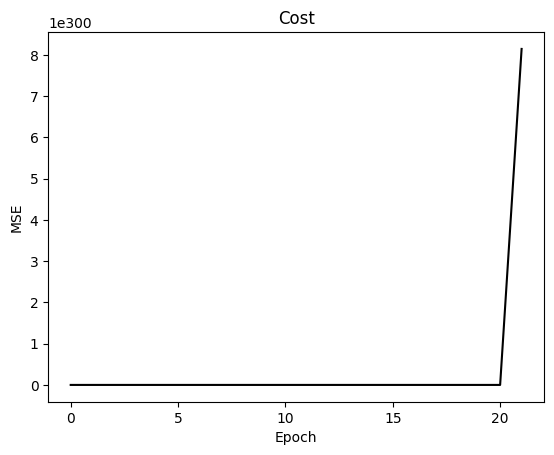

In [114]:
## Resposta Q4.a ##
import matplotlib.pyplot as plt

def GD(X, y, epoch, alpha = 0.1):                     #define o algoritmo do Gradiente Descendente
    w = np.zeros((X.shape[1],1))                         # Inicializa parâmetros em 0
    errorHistory = np.zeros(epoch)
    t = 0                                                #define t
    for t in range(epoch):                               #enquanto t for menor ou igual ao máximo
        pred = X @ w                                     #calcula ŷ
        error = y - pred                                 #calcula o erro
        
        w = w + alpha * (X.T @ error)/error.shape[0]     #atualiza os parâmetros

        errorHistory[t] = mse(y, pred)                   #guarda o MSE em um histórico
        
    return [errorHistory, w]                             #retorna o histórico e os parâmetros
    
results = GD(X_train, y_train, 70)

plt.title("Cost")
plt.plot(results[0], color="black")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

#### b) Normalize as variáveis preditivas usando o método min-max e a variável alvo usando o método z-score. Repita o procedimento do item A.

(436, 20) (436, 2)


C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\2783138253.py:4: RuntimeWarning: invalid value encountered in divide
  X_train_normalized = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))


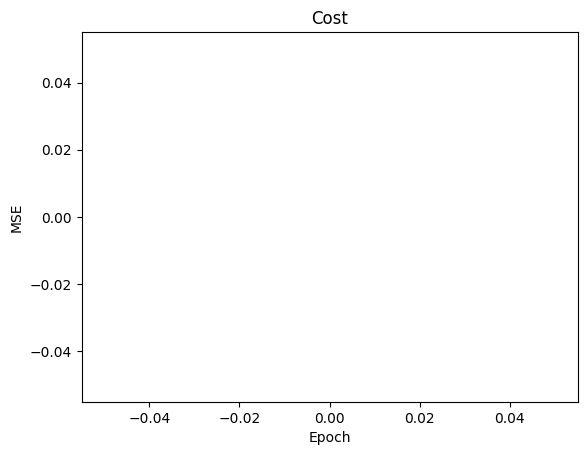

In [147]:
#Normalizar de forma diferente ao mesmo tempo parece uma má ideia, mas ok

# Normalize as variáveis preditivas
X_train_normalized = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))

# Normalize a variável alvo
y_train_normalized = (y_train - np.mean(y_train)) / np.std(y_train)

print(X_train_normalized.shape, y_train_normalized.shape)

results = GD(X_train_normalized, y_train_normalized, 70)

plt.title("Cost")
plt.plot(results[0], color="black")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

Porque isso não funciona? É por causa do One-Hot Encoding? Faz ele tentar dividir por 0? Achei que tirando os dados correlacionados ajudaria, mas nada. Tá difícil.

#### c) Avalie o desempenho do modelo aplicado ao conjunto de dados normalizados, usando as métricas MSE e R².

Bem... é aqui que eu botaria o desempenho, se tivesse funcionando :^)  
Sem a normalização já não tava legal, agora lascou de vez

#### 5. Repita os procedimentos realizados no item 4, usando o método SGD (gradiente descendente estocástico) ao invés do GD

C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\3373133030.py:5: RuntimeWarning: overflow encountered in square
  return np.mean((y - pred) ** 2)
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\3660561841.py:16: RuntimeWarning: overflow encountered in multiply
  w = w + alpha * (PermX[[i]].T * error)           #atualiza os parâmetros. Se o PermX não for transposto, o w ganha uma dimensão extra
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\3660561841.py:16: RuntimeWarning: invalid value encountered in multiply
  w = w + alpha * (PermX[[i]].T * error)           #atualiza os parâmetros. Se o PermX não for transposto, o w ganha uma dimensão extra
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\3660561841.py:16: RuntimeWarning: invalid value encountered in add
  w = w + alpha * (PermX[[i]].T * error)           #atualiza os parâmetros. Se o PermX não for transposto, o w ganha uma dimensão extra
C:\Users\agar32\AppData\Local\Temp\ipykernel_37080\3660561841.py:10: RuntimeWarning:

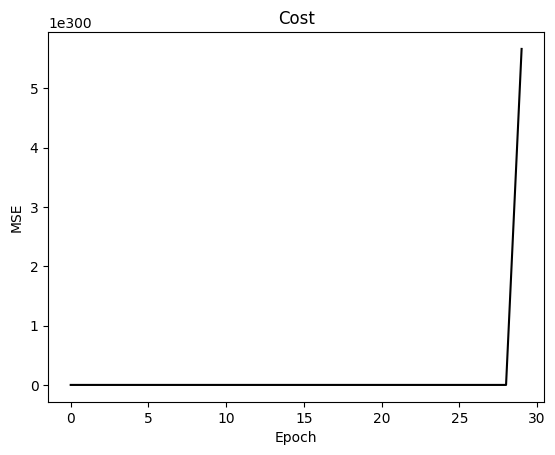

In [119]:
## Resposta Q4.c ##

def SGD(X, y, epoch, alpha = 0.001):                         #define o algoritmo do Gradiente Descendente
    w = np.zeros((X.shape[1],1))
    errorHistory = []
    t = 0                                                    #define t
    for t in range(epoch):                                   #enquanto t for menor ou igual ao máximo
        PermX = X                                            #np.random.permutation(X) (Aparentemente permutar o X em si não funciona) ¯\_(ツ)_/¯
        for i in np.random.permutation(X.shape[0]):          #range(X.shape[0]):// permuta o i ao invés do X agora
            pred = PermX[[i]] @ w                                   #calcula ŷ
            error = y[i] - pred                                 #calcula o erro
            #if ((t==15) and (i==15)): print("error:",error.shape)            #debugging
            #if ((t==15) and (i==15)): print("pred:",pred.shape)
            #if ((t==15) and (i==15)): print("PermX[[i]]:",PermX[[i]].shape)
            #if ((t==15) and (i==15)): print("w:",w.shape)
            w = w + alpha * (PermX[[i]].T * error)           #atualiza os parâmetros. Se o PermX não for transposto, o w ganha uma dimensão extra

            errorHistory.append(mse(y, X @ w))               #guarda o MSE em um histórico
        
    return [errorHistory, w]                                 #retorna o histórico e os parâmetros
    
results = SGD(X_train, y_train, 120)

plt.title("Cost")
plt.plot(results[0], color="black")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

#### 6. Treine 10 vezes o algoritmo GD, calculando o MSE e o R² sobre o conjunto de teste após cada iteração. Faça o mesmo com o algoritmo SGD. Faça um gráfico dos valores do MSE e R² para ambos os algoritmos. Compare esses valores com os obtidos com o método OLS. Por que esses valores variam tanto em cada treinamento? Você consegue propor uma mudança nesses algoritmos que melhore o desempenho?

Bem, está dando erro em todos eles, então não vai dar em nada. Mas seria só fazer os K-Folds e rodar os algoritmos. Imagine um gráfico aqui. Porque às vezes você pode pegar dados de treino/teste melhores e às vezes piores. Se eles estivessem funcionando eu já estava feliz.